In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
np.random.seed(151)

In [3]:
from sklearn.metrics import classification_report

# Deep Learningドリル - 応用編（画像処理）-

みなさんはここまでの演習でDeep Learningの基礎について学習してきました。ここまで理解していればもうDeep Learningで基本的なモデルを設計して実務で使うことができるでしょう。

ここでは基礎から一歩踏み出して、もっと応用的な問題に挑戦してみましょう。この章では、Deep Learningを使った画像処理について学びます。画像処理には欠かせないCNNについても実際に体験していただきます。

## 例題

あなたの務める会社では、自動運転システムを開発することになりました。あなたは開発プロジェクトの中で、標識認識部分のR&Dを担当しています。

標識の画像から種類を認識するデモシステムを作成してみましょう。

## データの準備

今回はフリーで公開されている標識画像データセットを使います。ただし、このデータの再配布について条件が明示されていないため、以下のURLから個別にダウンロードしてください。

* http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
* http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
* http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip

ダウンロードしたら、このファイル"6\_応用編\_画像処理.ipynb"と同じディレクトリにダウンロードしたZipファイルを置いて下さい。

以下の行を実行して、ダウンロードした3つのファイルが表示されれば成功です。

In [4]:
ls *.zip

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は 5028-F110 です

 C:\Users\Hiroshi.Hiromax\Downloads\Homework-master-ab83c0f2dc938cf3204ec3fcbaff174909161ba8 のディレクトリ

2017/11/12  15:56            99,620 GTSRB_Final_Test_GT.zip
2017/11/12  16:02        88,978,620 GTSRB_Final_Test_Images.zip
2017/11/12  16:19       276,294,756 GTSRB_Final_Training_Images.zip
               3 個のファイル         365,372,996 バイト
               0 個のディレクトリ  363,126,509,568 バイトの空き領域


解凍します。

In [5]:
import zipfile

In [6]:
with zipfile.ZipFile("GTSRB_Final_Training_Images.zip", "r") as fp:
    fp.extractall()

In [7]:
with zipfile.ZipFile("GTSRB_Final_Test_Images.zip", "r") as fp:
    fp.extractall()

In [8]:
with zipfile.ZipFile("GTSRB_Final_Test_GT.zip", "r") as fp:
    fp.extractall()

これで解凍されました。

In [9]:
ls GTSRB

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は 5028-F110 です

 C:\Users\Hiroshi.Hiromax\Downloads\Homework-master-ab83c0f2dc938cf3204ec3fcbaff174909161ba8\GTSRB のディレクトリ

2017/11/12  16:45    <DIR>          .
2017/11/12  16:45    <DIR>          ..
2017/11/12  16:41    <DIR>          Final_Test
2017/11/12  16:28    <DIR>          Final_Training
2017/11/19  19:23             2,568 Readme-Images.txt
2017/11/19  19:28             2,508 Readme-Images-Final-test.txt
               2 個のファイル               5,076 バイト
               4 個のディレクトリ  363,114,487,808 バイトの空き領域


Final_Trainingの中に学習データが含まれています。

In [10]:
from PIL import Image

中を覗いてみましょう。

In [11]:
Image.open("GTSRB/Final_Training/Images/00000/00000_00000.ppm")

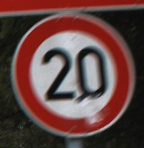

In [12]:
Image.open("GTSRB/Final_Training/Images/00000/00000_00029.ppm")

In [13]:
Image.open("GTSRB/Final_Training/Images/00042/00007_00001.ppm")

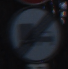

In [14]:
Image.open("GTSRB/Final_Training/Images/00042/00007_00029.ppm")

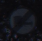

In [23]:
Image.open("GTSRB/Final_Training/Images/00042/00006_00020.ppm")

ディレクトリ部分の数字(000000や000042など)がクラス番号です。ファイル名の前半の数字が写真を撮影したトラックの番号、後半が写真の番号です。トラックは道をカメラをつけて走っていますので、後半の数字が大きくなればなるほど近づいていくわけですね。

## 画像のロード

それではさっそく初めましょう。まずは画像をnumpy配列にロードします。

In [25]:
import os

In [26]:
class Datum(object):
    def __init__(self, vector, label, filename):
        self.vector = vector
        self.label = label
        self.filename = filename

In [27]:
train = []
for dirpath, _, filenames in os.walk("GTSRB/Final_Training/Images"):
    for filename in filenames:
        if filename.endswith(".ppm"):
            path = os.path.join(dirpath, filename)
            dirname = os.path.basename(dirpath)
            img = Image.open(path)
            vector = np.asarray(img)
            train.append(Datum(vector, int(dirname), filename))

In [28]:
from glob import glob
import csv

In [29]:
ground_truth = dict()
with open("GT-final_test.csv") as fp:
    reader = csv.reader(fp, delimiter=";")
    for row in reader:
        filename = row[0]
        class_id = row[7]
        ground_truth[filename] = class_id

test = []
for path in glob("GTSRB/Final_Test/Images/*.ppm"):
    filename = os.path.basename(path)
    label = ground_truth[filename]
    img = Image.open(path)
    vector = np.asarray(img)
    test.append(Datum(vector, int(label), path))

データ数を確認しましょう。

In [30]:
len(train)

39209

In [31]:
len(test)

12630

データのフォーマットを確認しておきましょう。

画像はDatum.vectorに保存されています。

In [32]:
train[0].vector.shape

(30, 29, 3)

実際の画像と見比べるとわかりますが、shapeは(行, 列, 色)の順に並んでいます。

正解ラベルはDatum.labelに格納されています。

In [23]:
train[0].label

0

画像サイズは1枚ずつ異なります。Deep Learningのモデルは異る長さのデータを受けとれないため、サイズを統一する必要がありますね。ここでは32x32に変換しましょう。

In [24]:
import scipy.misc

In [25]:
for d in train:
    d.vector = scipy.misc.imresize(d.vector, (32, 32))

In [26]:
for d in test:
    d.vector = scipy.misc.imresize(d.vector, (32, 32))

データを確認しましょう。

In [27]:
train[0].vector.shape

(32, 32, 3)

## 前処理

処理を簡単にするため、データをすべて一つのデータにしてしまいましょう。

In [28]:
train_x = np.empty((len(train), 32, 32, 3), dtype=np.float32)
train_y = np.empty((len(train),), dtype=np.int32)

for i, d in enumerate(train):
    train_x[i, :, : ,:] = d.vector
    train_y[i] = d.label

In [29]:
test_x = np.empty((len(test), 32, 32, 3), dtype=np.float32)
test_y = np.empty((len(test),), dtype=np.int32)

for i, d in enumerate(test):
    test_x[i, :, : ,:] = d.vector
    test_y[i] = d.label

In [30]:
train_x.shape, train_y.shape

((39209, 32, 32, 3), (39209,))

学習データから開発データをとりわけておきましょう。

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size=0.1, random_state=11)

In [33]:
train_x.shape, dev_x.shape, train_y.shape, dev_y.shape

((35288, 32, 32, 3), (3921, 32, 32, 3), (35288,), (3921,))

Scikit-LearnのStandardScalerは2次元までしか対応していませんので、自力で書きます。

In [34]:
class StandardScaler3d(object):
    def __init__(self):
        self.mean_ = None
        self.var_ = None
    
    def fit_transform(self, x):
        self.mean_ = np.mean(x, axis=0)
        self.var_ = np.var(x, axis=0, ddof=1)
        return self.transform(x)
    
    def transform(self, x):
        return (x - self.mean_) / self.var_

In [35]:
scaler = StandardScaler3d()

In [36]:
train_x = scaler.fit_transform(train_x)

In [37]:
dev_x = scaler.transform(dev_x)

In [38]:
test_x = scaler.transform(test_x)

さて、chainerでは、(データ, 色, 行, 列)の順にデータを並べる必要があります。並び変えには numpy.transpose を使います。

In [39]:
train_x = np.transpose(train_x, (0, 3, 1, 2))
dev_x = np.transpose(dev_x, (0, 3, 1, 2))
test_x = np.transpose(test_x, (0, 3, 1, 2))

In [40]:
train_x.shape, dev_x.shape, test_x.shape

((35288, 3, 32, 32), (3921, 3, 32, 32), (12630, 3, 32, 32))

## モデル

いよいよChainerでのモデル設計を行います。

In [41]:
from chainer import Chain, configuration
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater, Trainer
from chainer.training.extensions import PrintReport, LogReport, Evaluator

In [1]:
class Model(Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(3, 3, ksize=5)
            self.batch1 = L.BatchNormalization(3)
            self.conv2 = L.Convolution2D(3, 1, ksize=3)
            self.batch2 = L.BatchNormalization(1)
            self.fc1 = L.Linear(100)
            self.fc2 = L.Linear(43)
    
    def __call__(self, X):
        h = self.conv1(X)
        h = F.max_pooling_2d(h, ksize=3)
        h = F.relu(h)
        h = self.batch1(h)
        
        h = self.conv2(h)
        h = F.max_pooling_2d(h, ksize=3)
        h = F.relu(h)
        h = self.batch2(h)
        
        h = F.reshape(h, (X.shape[0], np.prod(h.shape[1:])))
        
        h = self.fc1(h)
        h = F.dropout(h, ratio=0.5)
        h = F.relu(h)
        return self.fc2(h)

NameError: name 'Chain' is not defined

In [2]:
model = Model()
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)
train_dataset = TupleDataset(train_x, train_y)
dev_dataset = TupleDataset(dev_x, dev_y)
test_dataset = TupleDataset(test_x, test_y)
train_iterator = SerialIterator(train_dataset, batch_size=100, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=100, shuffle=False, repeat=False)
test_iterator = SerialIterator(test_dataset, batch_size=100, shuffle=False, repeat=False)
updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (10000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(100, 'iteration'), name="dev")
trainer.extend(Evaluator(test_iterator, classifier), trigger=(100, 'iteration'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss", "test/main/loss"]))

logreport = LogReport(trigger=(100, 'iteration'))
trainer.extend(logreport)
trainer.run()

NameError: name 'Model' is not defined

学習に大変長い時間がかかりましたね。学習時間を短くするため、通常はGPUを使います。

In [ ]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "dev/main/loss"]].values, columns=["main/loss", "dev/main/loss"], index=log_df["iteration"]).plot()

性能も見ておきましょう。性能は、log_dfの中に記録されています。

In [ ]:
log_df.tail()

分類性能を確認しましょう。

In [ ]:
with configuration.using_config('train', False):
    predicts = model(dev_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Dev data ***")
print(classification_report(dev_y, predicts_y))

with configuration.using_config('train', False):
    predicts = model(test_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Test data ***")
print(classification_report(test_y, predicts_y))

完全にランダムであれば1/43ですから、そこそこ性能が出ていることがわかります。

## Data Augmentation

Data Augmentationは学習データを水増しすることでモデルの性能向上を狙う手法です。Deep Learningで画像処理を行なう場合、モデルが大規模化しやすい傾向にあります。大規模なモデルを学習するには、学習データも大量に必要になります。実務において、有り余る学習データを使える場合は稀ですので通常はこの手法を使ってデータを増やします。

In [ ]:
from scipy import ndimage

画像の形を変換するのはアフィン変換という手法を使います。
簡単に説明すると、画像の変換は画像の行列に対して変換行列を作用させたものとして取り扱うことができるというものです。
ですので、画像を変換するために、変換行列を用意しなければいけません。

天下り式ですが、回転と拡大を同時に行なう変換行列は以下のように書けます。(sは拡大率, aは回転の角度)
興味のあるかたは調べてみてください。

\begin{eqnarray}
A &=& \left[
\begin{array}{ll}
s & 0\\
0 & s
\end{array}
\right]
\left[
\begin{array}{ll}
\cos a & -\sin a\\
\sin a & \cos a\\
\end{array}
\right]\\
&=& s \times \left[
\begin{array}{ll}
\cos a & -\sin a\\
\sin a & \cos a\\
\end{array}
\right]
\end{eqnarray}

In [ ]:
class AugmentedDataset(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.angle = None
        self.scale = None
        self.diff = None
    
    def __getitem__(self, index):
        x = self.x[index].copy()
        y = self.y[index].copy()
        
        if len(x.shape) != 3:
            print(x.shape)
            raise ValueError
        
        self.angle = np.random.normal(scale=0.1) # 回転角
        self.scale = np.random.normal(loc=1, scale=0.1) # 拡大・縮小
        self.diff = np.random.normal(scale=2, size=2) # 移動
        
        matrix = np.array(
            [[np.cos(self.angle), -np.sin(self.angle)], 
             [np.sin(self.angle), np.cos(self.angle)]], 
            dtype=np.float32
        ) * self.scale
        
        # 回転中心を画像の中心にする
        # 参考: https://stackoverflow.com/questions/20161175/how-can-i-use-scipy-ndimage-interpolation-affine-transform-to-rotate-an-image-ab
        center = np.array(x.shape[1:], dtype=np.float32) / 2
        mapped = center.dot(matrix)
        d = center - mapped
        x[0] = ndimage.affine_transform(x[0], matrix.T, offset=d)
        x[1] = ndimage.affine_transform(x[1], matrix.T, offset=d)
        x[2] = ndimage.affine_transform(x[2], matrix.T, offset=d)
        
        return x, y
        
    def __len__(self):
        return len(self.x)

In [ ]:
train_dataset_aug = AugmentedDataset(train_x, train_y)

これで画像を毎回少しずつ揺らしながら返すdatasetができました。試しに実行してみましょう。

In [ ]:
img = np.transpose(train_dataset_aug[0][0], (1, 2, 0))
m = img.max()

print(train_dataset_aug.angle, train_dataset_aug.scale, train_dataset_aug.diff)
Image.fromarray((img / m * 255).astype(np.uint8))

In [ ]:
model_aug = Model()
classifier_aug = L.Classifier(model_aug)
optimizer_aug = Adam()
optimizer_aug.setup(classifier_aug)
train_iterator_aug = SerialIterator(train_dataset_aug, batch_size=100, repeat=True)
updater_aug = StandardUpdater(train_iterator_aug, optimizer_aug, loss_func=classifier_aug)
trainer_aug = Trainer(updater_aug, (10000, 'iteration'))
trainer_aug.extend(Evaluator(dev_iterator, classifier_aug), trigger=(100, 'iteration'), name="dev")
trainer_aug.extend(Evaluator(test_iterator, classifier_aug), trigger=(100, 'iteration'), name="test")
trainer_aug.extend(PrintReport(['iteration', "main/loss", "dev/main/loss", "test/main/loss"]))

logreport_aug = LogReport(trigger=(100, 'iteration'))
trainer_aug.extend(logreport_aug)
trainer_aug.run()

In [ ]:
log_aug_df = pd.DataFrame(logreport_aug.log)
pd.DataFrame(log_df[["main/loss", "dev/main/loss"]].values, columns=["main/loss", "dev/main/loss"], index=log_df["iteration"]).plot()

In [ ]:
log_aug_df.tail()

いかがですか？Data Augmentationなしの場合に比べて、開発データに対する収束が多少早くなっているのがわかると思います。(学習データに対するロスは、データが揺らされているため比較できません。開発データは同じものを使っているため比較可能です)

このように、学習データをランダムに少しだけゆらすことで、データの揺らぎに強いモデルの学習が可能になります。(データの揺らぎに強いデータのことを __ロバストなモデル__ と言います。)

最後に、分類性能を確認しておきましょう。

In [ ]:
with configuration.using_config('train', False):
    predicts = model_aug(dev_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Dev data ***")
print(classification_report(dev_y, predicts_y))

with configuration.using_config('train', False):
    predicts = model_aug(test_x)
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Test data ***")
print(classification_report(test_y, predicts_y))

Data Augumentationによって性能が改善したことを確認してください。